In [1]:
import plyfile
import numpy as np
import matplotlib.pyplot as plt

### Load data ###

In [2]:
def load_cow(every_ith=200):
    from plyfile import PlyData
    plydata = PlyData.read('cow.2D.ply')

    X = np.array([plydata["vertex"][c] for c in ["y", "x"]]).T
    X[:,1] = -X[:,1]
    N = np.array([plydata["vertex"][c] for c in ["ny", "nx"]]).T
    N[:,1] = -N[:,1]
    return X[::every_ith],N[::every_ith]

(500, 2)
(500, 2)


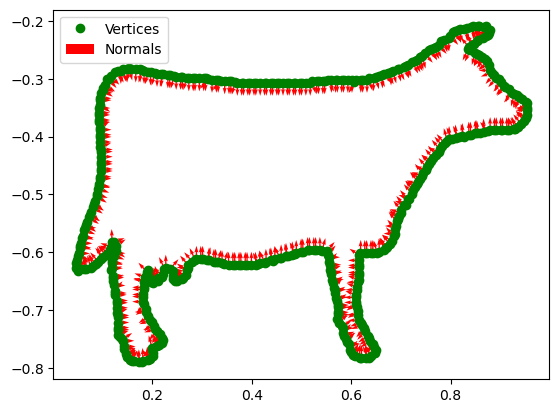

In [3]:
data = load_cow()
print(data[0].shape)
print(data[1].shape)
X, N = data[0], data[1]
plt.plot(X[:,0], X[:,1], 'o', color='g',label="Vertices")
plt.quiver(X[:, 0], X[:, 1], N[:, 0], N[:, 1], angles='xy', scale_units='xy', color='r', label="Normals")
plt.legend()
plt.show()


### Define Triangulation ###

In [4]:
def compute_bounding_box(X):
    min_x = np.min(X[:,0])
    max_x = np.max(X[:,0])
    min_y = np.min(X[:,1])
    max_y = np.max(X[:,1])
    return min_x, max_x, min_y, max_y

def compute_grid(X, min_x, max_x, min_y, max_y, res=0.1, padding=0.2):
    x = np.linspace(min_x - padding, max_x + padding, int((max_x - min_x) / res))
    y = np.linspace(min_y - padding, max_y + padding, int((max_y - min_y) / res))
    X, Y = np.meshgrid(x, y)
    return X, Y

In [72]:
# define grid domain
bounding_box = compute_bounding_box(X)
regular_grid = compute_grid(X, *bounding_box, res=0.04, padding=0.1)

points = np.array([regular_grid[0].ravel(), regular_grid[1].ravel()]).T
print(points.shape)
print(points[0])

(308, 2)
[-0.053478   -0.89009801]


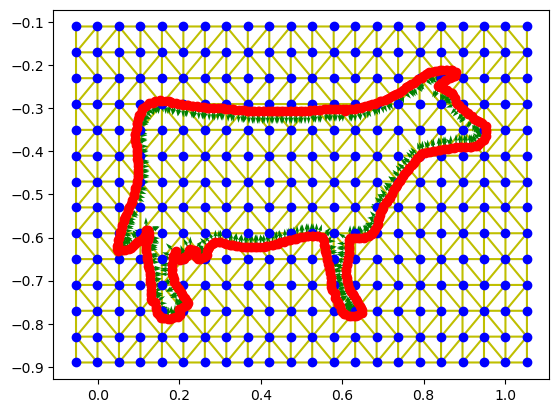

In [73]:
# compute Delaunay triangulation
from scipy.spatial import Delaunay
triangulation = Delaunay(points)
plt.triplot(points[:,0], points[:,1], triangulation.simplices, color='y')
plt.plot(points[:,0], points[:,1], 'o', color='b')
plt.plot(X[:,0], X[:,1], 'o', color='r')
plt.quiver(X[:, 0], X[:, 1], N[:, 0], N[:, 1], angles='xy', scale_units='xy', color='g', label="Normals")
plt.show()

### Compute $V$ ###

In [74]:
def compute_gradient_per_vertex(points, X, N, sigma=1.0):
    V = np.zeros((len(points), 2))
    for i in range(len(points)):
        for j in range(len(X)):
            weight = (np.exp(-np.linalg.norm(points[i] - X[j])**2 / (2 * np.pi * sigma**2)))
            V[i] += weight * N[j]
    return V

def compute_gradient_per_face(triangulation, V):
    F = np.zeros((len(triangulation.simplices), 2))
    for i, t in enumerate(triangulation.simplices):
        # Get the indices of the vertices of the triangle
        v0, v1, v2 = t

        # Get the vertex gradients
        grad0 = V[v0]
        grad1 = V[v1]
        grad2 = V[v2]

        # Compute the barycentric interpolation (uniform averaging)
        face_gradient = (grad0 + grad1 + grad2) / 3.0

        # Store the face gradient
        F[i] = face_gradient
    return F

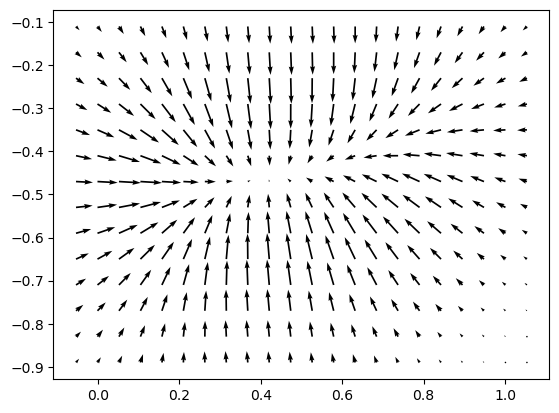

In [75]:
# visualize V for each vertex
V_vertex = compute_gradient_per_vertex(points, X, N, sigma=0.1)
plt.quiver(points[:,0], points[:,1], V_vertex[:,0], V_vertex[:,1])
plt.show()

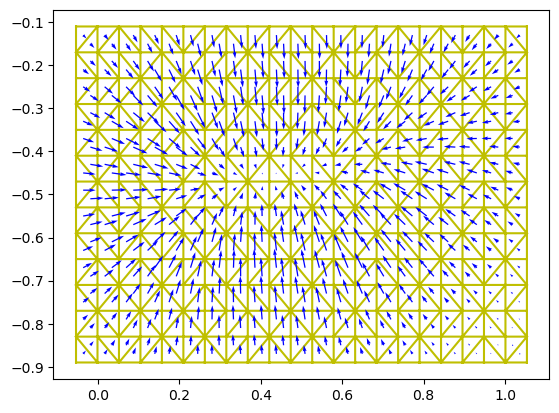

In [76]:
# visualize V for each face
V_face = compute_gradient_per_face(triangulation, V_vertex)
plt.triplot(points[:,0], points[:,1], triangulation.simplices, color='y')
centroids = np.mean(points[triangulation.simplices], axis=1)
plt.quiver(centroids[:,0], centroids[:,1], V_face[:,0], V_face[:,1], color='blue', scale_units='xy')
plt.show()


### Compute gradient, divergence, Laplacian ###

In [77]:
from gpytoolbox import grad, cotangent_laplacian, massmatrix
G = grad(points, triangulation.simplices) # compute discrete gradient assuming piecewise linear hat function basis
L = cotangent_laplacian(points, triangulation.simplices)
M = massmatrix(V=V_face, F=triangulation.simplices)

# compute discrete divergence
D = -G.T @ ( M @ V_face ).flatten()

# solve the Poisson equation Ac = b <-> Lc = D
from scipy.sparse import linalg
A = L
b = D
c = linalg.spsolve(A, b)

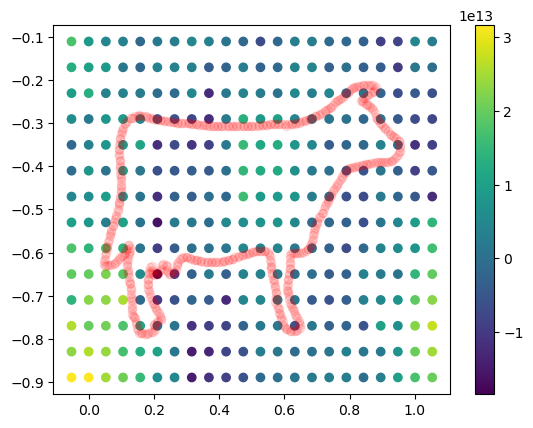

In [78]:
# visualize the solution for every vertex
plt.scatter(points[:, 0], points[:, 1], cmap='viridis', c=c) # with piecewise linear hat function basis, implicit function value at each vertex is just the corresponding coefficient
plt.plot(X[:,0], X[:,1], 'o', color='r', alpha=0.1)
plt.colorbar()
plt.show()